# Togo Solar Farm Data Analysis
# 
##### This notebook analyzes solar farm data from togo to identify patterns and optimize solar panel performance.
#### The analysis focuses on:
# 
- Solar irradiance components (GHI, DNI, DHI)
- Environmental parameters (temperature, wind speed, humidity)
- Module performance before and after cleaning


## Import libraries

In [36]:
# Import necessary libraries
import os
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [60]:
# Add project root to Python path for custom module imports
sys.path.append(os.path.abspath(os.path.join(os.path.dirname("__file__"), '..')))
from src.data_processing.cleaning import remove_outliers, handle_missing_values
# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
# Set plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

##### Data Loading and Exploration


In [ ]:
# Load the dataset
df_togo = pd.read_csv(r'..\src\togo.csv')

##### Explore data

In [ ]:
# Display basic information about the dataset
print("Dataset Information:")
df_togo.info()

print("\nSummary Statistics:")
df_togo.describe()

print("\nMissing Values:")
print(df_togo.isna().sum())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525600 entries, 0 to 525599
Data columns (total 19 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Timestamp      525600 non-null  object 
 1   GHI            525600 non-null  float64
 2   DNI            525600 non-null  float64
 3   DHI            525600 non-null  float64
 4   ModA           525600 non-null  float64
 5   ModB           525600 non-null  float64
 6   Tamb           525600 non-null  float64
 7   RH             525600 non-null  float64
 8   WS             525600 non-null  float64
 9   WSgust         525600 non-null  float64
 10  WSstdev        525600 non-null  float64
 11  WD             525600 non-null  float64
 12  WDstdev        525600 non-null  float64
 13  BP             525600 non-null  int64  
 14  Cleaning       525600 non-null  int64  
 15  Precipitation  525600 non-null  float64
 16  TModA          525600 non-null  float64
 17  TModB   

In [ ]:
# List columns with >5% nulls
null_percentage = (df_togo.isna().sum() / len(df_togo)) * 100
print("\nColumns with >5% missing values:")
print(null_percentage[null_percentage > 5])


Columns with >5% missing values:
Comments    100.0
dtype: float64


In [ ]:
# Display first few rows
df_togo.head()

,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments,has_outlier
0,2021-08-09 00:01,-1.2,-0.2,-1.1,0.0,0.0,26.2,93.4,0.0,0.4,0.1,122.1,0.0,998,0,0.0,26.3,26.2,NaN,False
1,2021-08-09 00:02,-1.1,-0.2,-1.1,0.0,0.0,26.2,93.6,0.0,0.0,0.0,0.0,0.0,998,0,0.0,26.3,26.2,NaN,False
2,2021-08-09 00:03,-1.1,-0.2,-1.1,0.0,0.0,26.2,93.7,0.3,1.1,0.5,124.6,1.5,997,0,0.0,26.4,26.2,NaN,False
3,2021-08-09 00:04,-1.1,-0.1,-1.0,0.0,0.0,26.2,93.3,0.2,0.7,0.4,120.3,1.3,997,0,0.0,26.4,26.3,NaN,False
4,2021-08-09 00:05,-1.0,-0.1,-1.0,0.0,0.0,26.2,93.3,0.1,0.7,0.3,113.2,1.0,997,0,0.0,26.4,26.3,NaN,False


##### Outlier Detection & Basic Cleaning

In [ ]:

# Define function to calculate Z-scores and identify outliers
def identify_outliers(df, columns, threshold=3):
    """Identify outliers using Z-score method"""
    outliers = pd.DataFrame()
    for col in columns:
        z_scores = np.abs(stats.zscore(df[col]))
        outliers[col] = z_scores > threshold
    return outliers

# Calculate Z-scores for key columns
key_columns = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']
outliers = identify_outliers(df_togo, key_columns)

# Count outliers in each column
print("Outlier counts by column:")
print(outliers.sum())

Outlier counts by column:
GHI         89
DNI          0
DHI       3738
ModA        27
ModB        63
WS        3109
WSgust    3500
dtype: int64


In [ ]:
# Flag rows with outliers
df_togo['has_outlier'] = outliers.any(axis=1)
outlier_rows = df_togo[df_togo['has_outlier']]
print(f"Total rows with outliers: {len(outlier_rows)} ({len(outlier_rows)/len(df_togo)*100:.2f}%)")


Total rows with outliers: 7740 (1.47%)


In [ ]:
# Clean the data using custom functions
df_cleaned = handle_missing_values(df_togo, method='interpolate')
# Remove outliers from irradiance components
irradiance_components = ['GHI', 'DNI', 'DHI']
for component in irradiance_components:
    df_cleaned = remove_outliers(df_cleaned, component)
# Check the effect of cleaning
print(f"Original data shape: {df_togo.shape}")
print(f"Cleaned data shape: {df_cleaned.shape}")
print(f"Removed {df_togo.shape[0] - df_cleaned.shape[0]} rows ({((df_togo.shape[0] - df_cleaned.shape[0])/df_togo.shape[0])*100:.2f}%)")

c:\Users\Villian\solar-challenge-week1-1\src\data_processing\cleaning.py:40: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  return data.interpolate()


Original data shape: (525600, 20)
Cleaned data shape: (521769, 20)
Removed 3831 rows (0.73%)


In [ ]:
df_cleaned.to_csv('../data/togo_clean.csv', index=False)

##### Time Series Analysis

C:\Users\Villian\AppData\Local\Temp\ipykernel_4004\2637361556.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_cleaned['GHI'].resample('M').mean().plot(label='Monthly Mean GHI', color='blue')
C:\Users\Villian\AppData\Local\Temp\ipykernel_4004\2637361556.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_cleaned['DNI'].resample('M').mean().plot(label='Monthly Mean DNI', color='red')
C:\Users\Villian\AppData\Local\Temp\ipykernel_4004\2637361556.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_cleaned['DHI'].resample('M').mean().plot(label='Monthly Mean DHI', color='green')


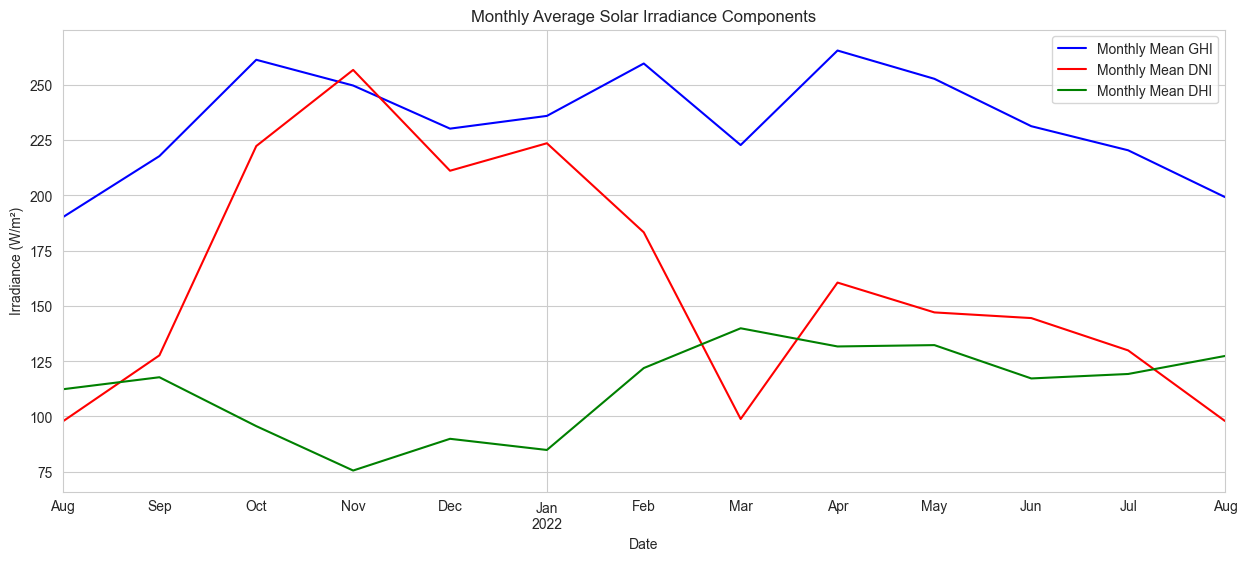

In [47]:

# Convert Timestamp to datetime
df_cleaned['Timestamp'] = pd.to_datetime(df_cleaned['Timestamp'])
df_cleaned.set_index('Timestamp', inplace=True)

# Plot monthly averages of irradiance components
plt.figure(figsize=(15, 6))
df_cleaned['GHI'].resample('M').mean().plot(label='Monthly Mean GHI', color='blue')
df_cleaned['DNI'].resample('M').mean().plot(label='Monthly Mean DNI', color='red')
df_cleaned['DHI'].resample('M').mean().plot(label='Monthly Mean DHI', color='green')
plt.title('Monthly Average Solar Irradiance Components')
plt.xlabel('Date')
plt.ylabel('Irradiance (W/m²)')
plt.legend()
plt.grid(True)
plt.show()

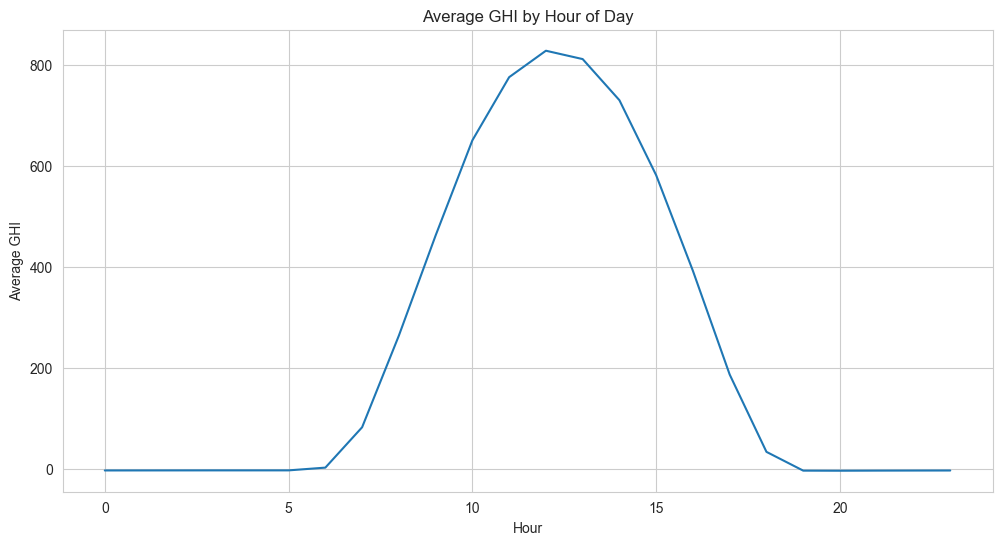

In [48]:
# Plot daily patterns
plt.figure(figsize=(12, 6))
df_cleaned.groupby(df_cleaned.index.hour)['GHI'].mean().plot()
plt.title('Average GHI by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Average GHI')
plt.grid(True)
plt.show()

##### Cleaning Impact Analysis

In [50]:

# Define function to calculate module averages
def calculate_module_averages(data, cleaning_flag='Cleaning'):
    """Calculate average module performance before and after cleaning"""
    # Filter data by cleaning status
    pre_clean = data[data[cleaning_flag] == 0]
    post_clean = data[data[cleaning_flag] == 1]
    
    # Calculate averages for each module
    results = {}
    for module in ['ModA', 'ModB']:
        pre_avg = pre_clean[module].mean()
        post_avg = post_clean[module].mean()
        results[module] = {'pre_clean': pre_avg, 'post_clean': post_avg}
    
    return results


In [51]:
# Calculate module performance before and after cleaning
module_stats = calculate_module_averages(df_cleaned)
# Display results
print("Module Performance Before and After Cleaning:")
for module, values in module_stats.items():
    pre = values['pre_clean']
    post = values['post_clean']
    improvement = ((post - pre) / pre) * 100
    print(f"{module}: {pre:.2f} → {post:.2f} ({improvement:.2f}% improvement)")

Module Performance Before and After Cleaning:
ModA: 232.55 → 307.23 (32.12% improvement)
ModB: 225.10 → 301.97 (34.15% improvement)


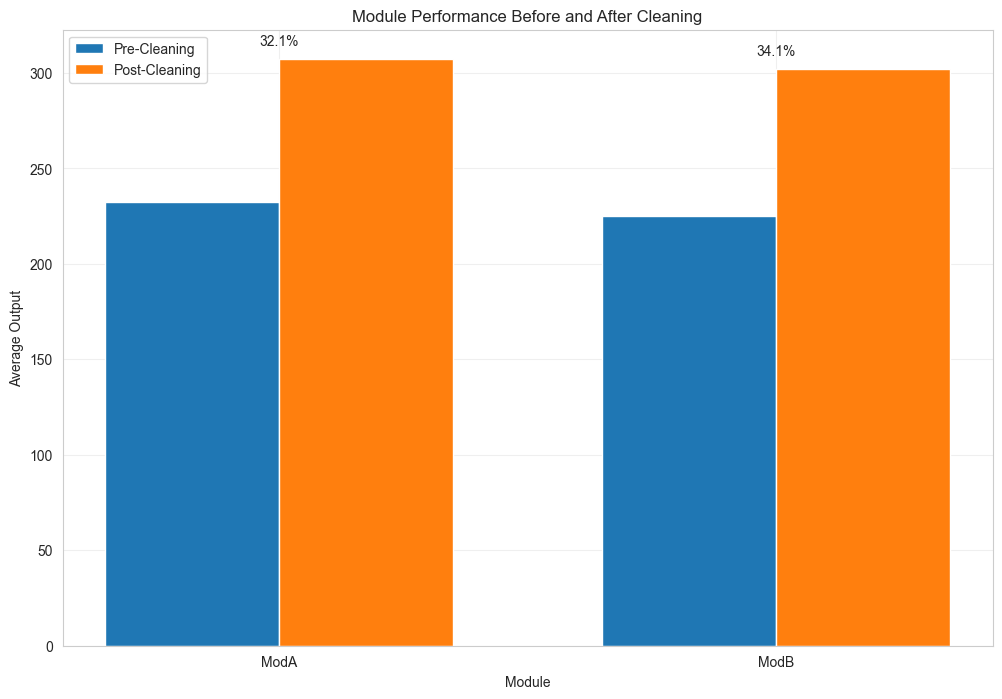

In [54]:
# Visualize the improvement
plt.figure(figsize=(12, 8))
modules = list(module_stats.keys())
pre_values = [module_stats[m]['pre_clean'] for m in modules]
post_values = [module_stats[m]['post_clean'] for m in modules]
x = np.arange(len(modules))
width = 0.35
plt.bar(x - width/2, pre_values, width, label='Pre-Cleaning')
plt.bar(x + width/2, post_values, width, label='Post-Cleaning')
plt.xlabel('Module')
plt.ylabel('Average Output')
plt.title('Module Performance Before and After Cleaning')
plt.xticks(x, modules)
plt.legend()
plt.grid(True, alpha=0.3)
# Add percentage improvement labels
for i, module in enumerate(modules):
    pre = module_stats[module]['pre_clean']
    post = module_stats[module]['post_clean']
    improvement = ((post - pre) / pre) * 100
    plt.annotate(f"{improvement:.1f}%", 
                 xy=(i, post), 
                 xytext=(0, 10),
                 textcoords="offset points",
                 ha='center')

plt.show()

##### Correlation & Relationship Analysis

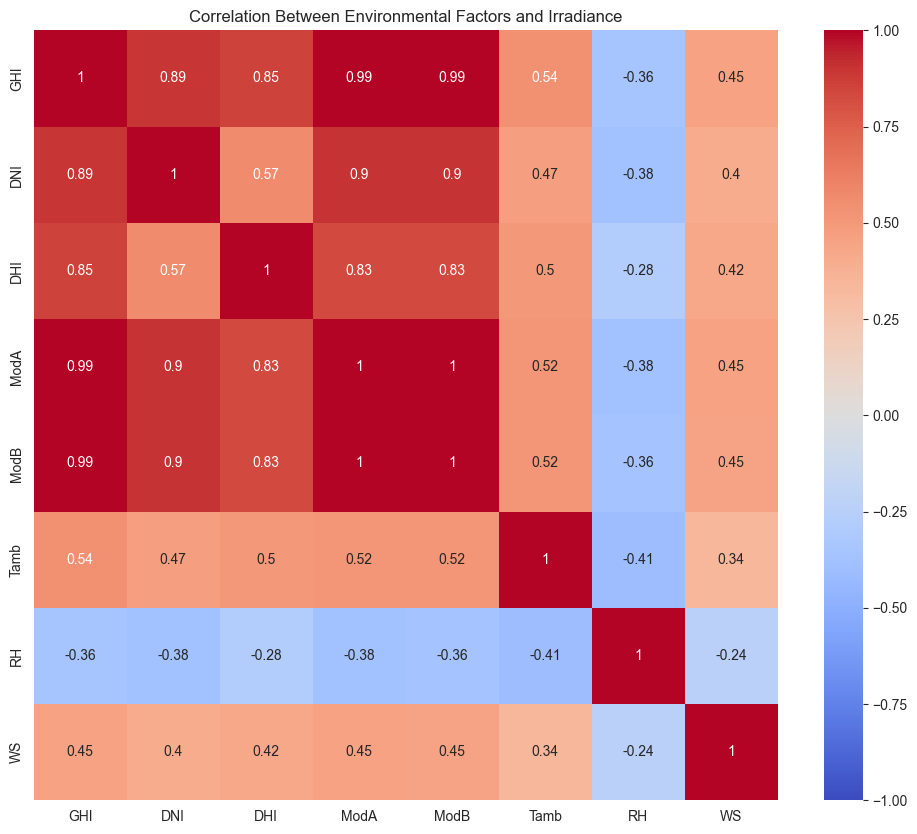

In [55]:

# Create correlation heatmap
plt.figure(figsize=(12, 10))
all_factors = irradiance_components + ['ModA', 'ModB', 'Tamb', 'RH', 'WS']
sns.heatmap(df_cleaned[all_factors].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Between Environmental Factors and Irradiance')
plt.show()


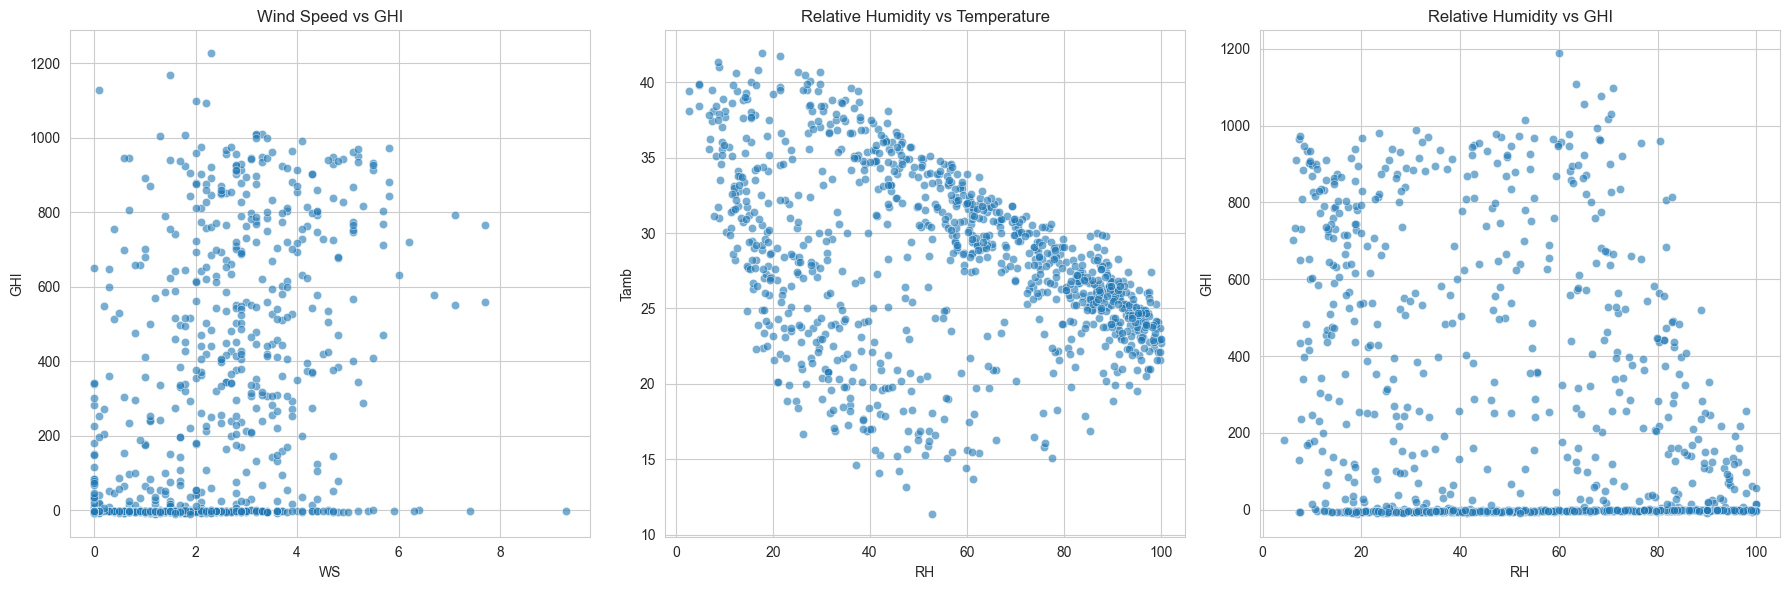

In [ ]:
# Scatter plots for environmental relationships
plt.figure(figsize=(18, 6))
# WS vs GHI
plt.subplot(1, 3, 1)
sns.scatterplot(x='WS', y='GHI', data=df_cleaned.sample(1000), alpha=0.6)
plt.title('Wind Speed vs GHI')
# RH vs Tamb
plt.subplot(1, 3, 2)
sns.scatterplot(x='RH', y='Tamb', data=df_cleaned.sample(1000), alpha=0.6)
plt.title('Relative Humidity vs Temperature')
# RH vs GHI
plt.subplot(1, 3, 3)
sns.scatterplot(x='RH', y='GHI', data=df_cleaned.sample(1000), alpha=0.6)
plt.title('Relative Humidity vs GHI')
plt.tight_layout()
plt.show()

##### Distribution Analysis

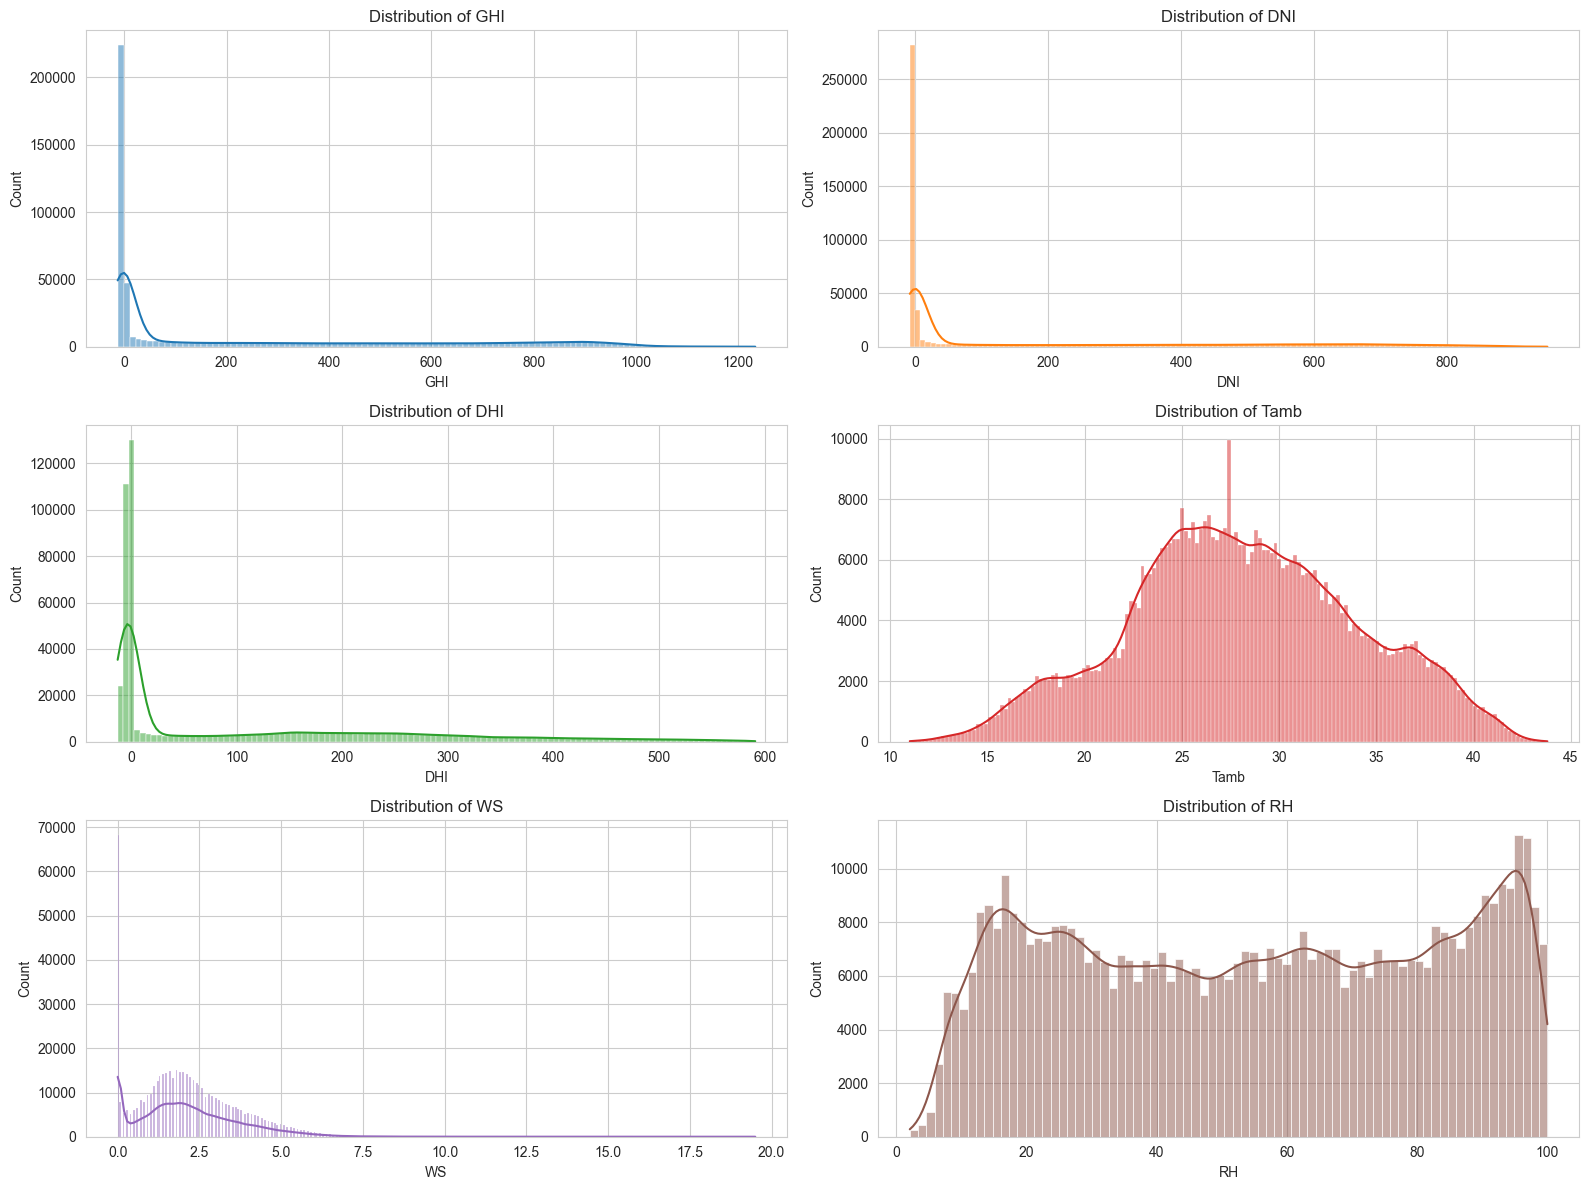

In [57]:

# Plot distributions of key variables
plt.figure(figsize=(16, 12))
features = ['GHI', 'DNI', 'DHI', 'Tamb', 'WS', 'RH']
for i, col in enumerate(features):
    plt.subplot(3, 2, i + 1)
    sns.histplot(df_cleaned[col], kde=True, color=f"C{i}")
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

##### Temperature Analysis

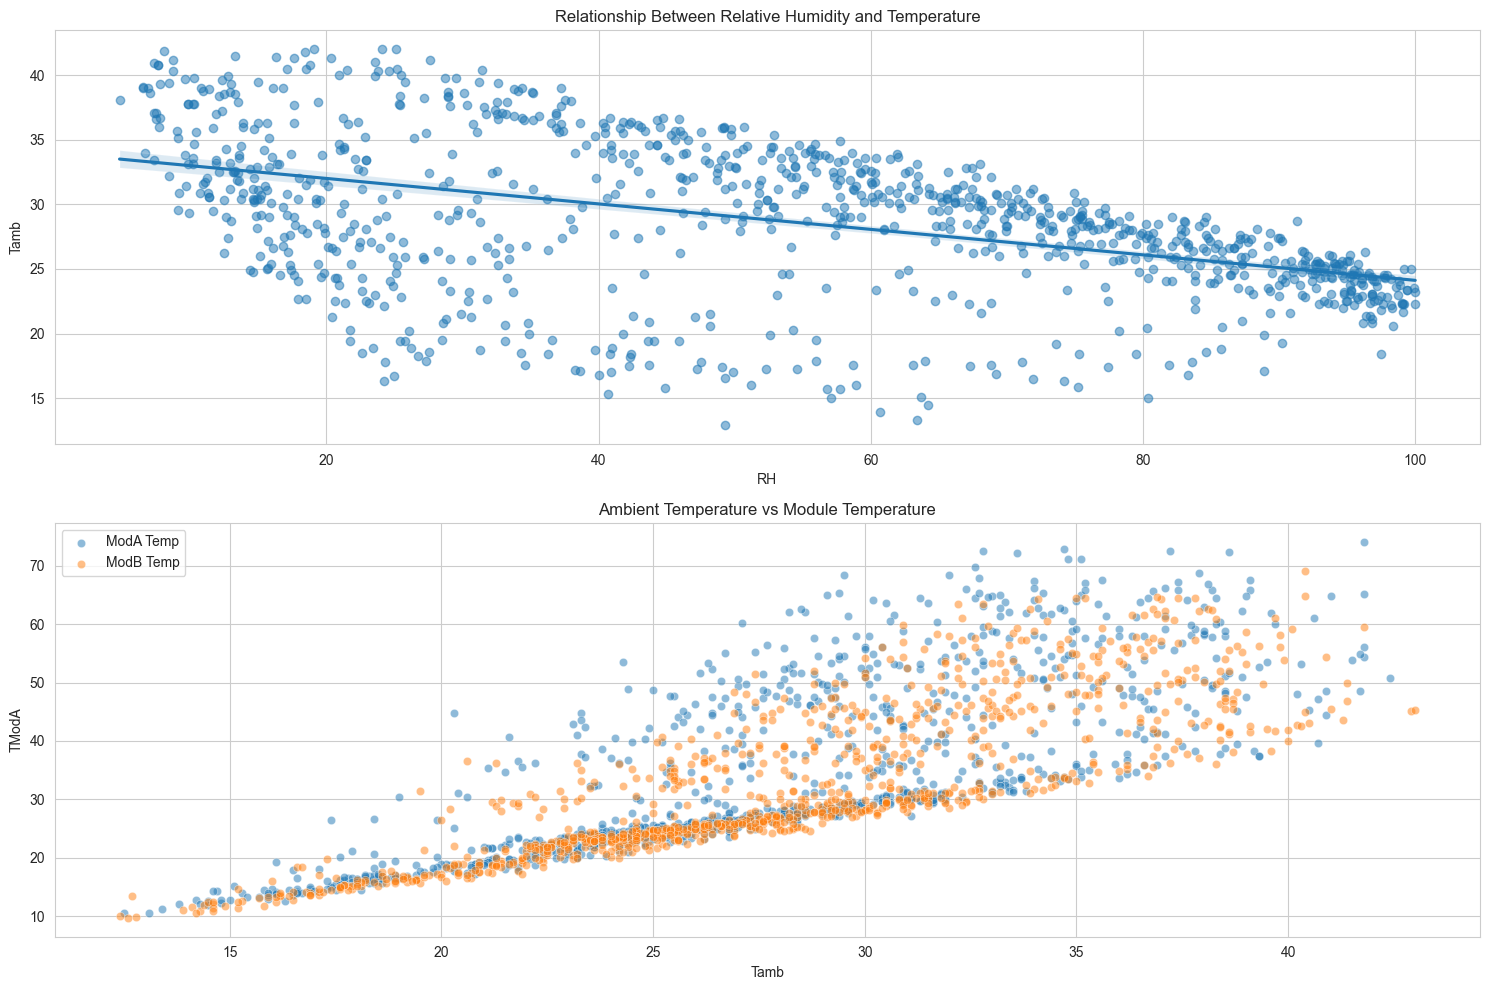

In [58]:

# Examine temperature relationships
plt.figure(figsize=(15, 10))
# Temperature vs RH scatter with regression line
plt.subplot(2, 1, 1)
sns.regplot(x='RH', y='Tamb', data=df_cleaned.sample(1000), scatter_kws={'alpha':0.5})
plt.title('Relationship Between Relative Humidity and Temperature')
# Temperature vs Module Temperature
plt.subplot(2, 1, 2)
sns.scatterplot(x='Tamb', y='TModA', data=df_cleaned.sample(1000), alpha=0.5, label='ModA Temp')
sns.scatterplot(x='Tamb', y='TModB', data=df_cleaned.sample(1000), alpha=0.5, label='ModB Temp')
plt.title('Ambient Temperature vs Module Temperature')
plt.legend()
plt.tight_layout()
plt.show()

#####  Bubble Chart

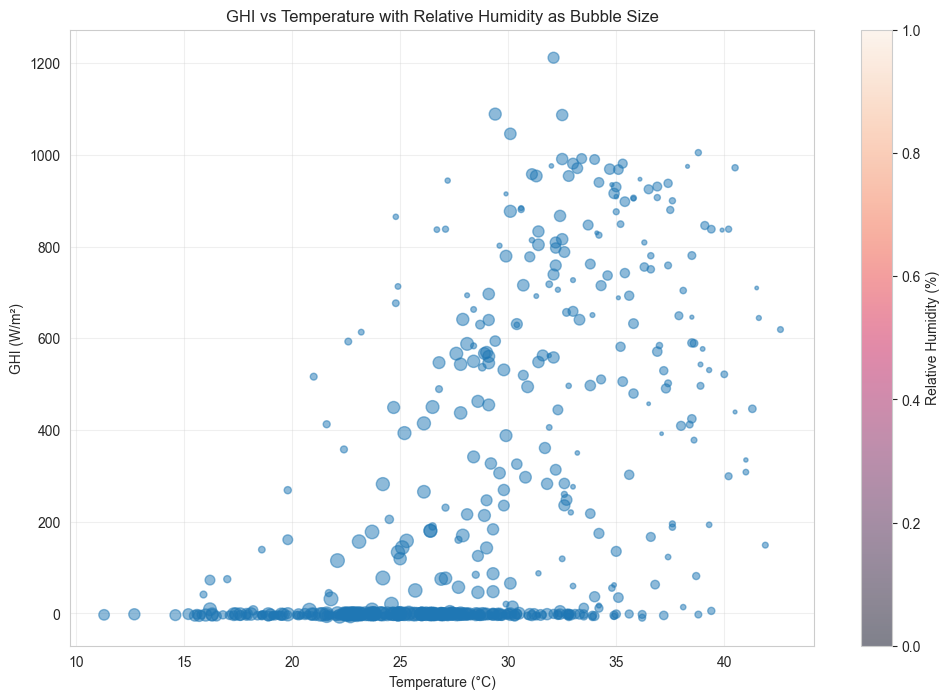

In [59]:

# Create bubble chart of GHI vs Tamb with RH as bubble size
plt.figure(figsize=(12, 8))
sample = df_cleaned.sample(500)
plt.scatter(sample['Tamb'], sample['GHI'], s=sample['RH'], alpha=0.5)
plt.title('GHI vs Temperature with Relative Humidity as Bubble Size')
plt.xlabel('Temperature (°C)')
plt.ylabel('GHI (W/m²)')
plt.colorbar(label='Relative Humidity (%)')
plt.grid(True, alpha=0.3)
plt.show()